# Import Libraries

In [52]:
import pandas as pd
import re
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf


# Load and Preprocess the Data

In [53]:
# Load dataset
file_path = 'mbti_1.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Original Dataset:")
display(data.head())

# Clean and preprocess text
def clean_text(text):
    text = text.replace('|||', ' ')
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['cleaned_posts'] = data['posts'].apply(clean_text)

# Display a sample of cleaned data
print("\nCleaned Data Sample:")
display(data[['type', 'cleaned_posts']].head())


Original Dataset:


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...



Cleaned Data Sample:


,type,cleaned_posts
0,INFJ,enfp and intj moments sportscenter not top ten...
1,ENTP,i m finding the lack of me in these posts very...
2,INTP,good one _____ of course to which i say i know...
3,INTJ,dear intp i enjoyed our conversation the other...
4,ENTJ,you re fired that s another silly misconceptio...


# Transform Text Data Using TF-IDF

In [54]:
# Use TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform text data
tfidf_features = tfidf.fit_transform(data['cleaned_posts'])

# Convert TF-IDF features to a DataFrame
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df['type'] = data['type']

# Display a sample of TF-IDF features
print("\nTF-IDF Features Sample:")
display(tfidf_df.head())



TF-IDF Features Sample:


,abandoned,abilities,ability,able,abortion,abroad,absence,absent,absolute,absolutely,...,youth,youtube,yrs,yup,zen,zero,zodiac,zombie,zombies,zone
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.069341,0.0,0.000000,0.026908,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.093674,0.032492,0.0,0.0,0.0,0.0,0.00000,0.078196,...,0.0,0.0,0.0,0.059877,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.059602,0.0,0.0,0.0,0.0,0.05603,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


#  Encode Target Variable

In [55]:
# Encode MBTI types as integers
y = data['type']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert to one-hot encoding for multi-class classification
y_one_hot = to_categorical(y_encoded)

print("\nOne-Hot Encoded Target Variable:")
print(y_one_hot[:5])



One-Hot Encoded Target Variable:
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Split Data into Training and Testing Sets

In [56]:
# Split data into training 80% and testing 20% sets
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_df.drop('type', axis=1),
    y_one_hot,
    test_size=0.2,
    random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (6940, 4999)
Test data shape: (1735, 4999)


# Build the Neural Network Model

In [57]:
# Build the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)),
    Dropout(0.3),
    Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # Output layer for multi-class classification
])

# Display model summary
model.summary()


c:\Users\pjosh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 649,296 (2.48 MB)

 Trainable params: 649,296 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the Model

In [58]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the Model

In [59]:
# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[reduce_lr]
)


Epoch 1/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1498 - loss: 2.6358 - val_accuracy: 0.2133 - val_loss: 2.2831 - learning_rate: 0.0010
Epoch 2/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2454 - loss: 2.3333 - val_accuracy: 0.3458 - val_loss: 2.2043 - learning_rate: 0.0010
Epoch 3/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3346 - loss: 2.2167 - val_accuracy: 0.4599 - val_loss: 2.1442 - learning_rate: 0.0010
Epoch 4/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3774 - loss: 2.1751 - val_accuracy: 0.4427 - val_loss: 2.0976 - learning_rate: 0.0010
Epoch 5/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4231 - loss: 2.1150 - val_accuracy: 0.4870 - val_loss: 2.0785 - learning_rate: 0.0010
Epoch 6/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4456 - loss: 2.0978 - val_accuracy: 0.4726 - val_loss: 2.0390 - learning_rate: 0.0010
Epoch 7/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4725 - loss: 2.0481 -

# Evaluate the Model

In [60]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Display training and test accuracy
print(f"Final Test Accuracy: {test_accuracy:.2f}")
print(f"Final Test Loss: {test_loss:.2f}")

# Access training and validation accuracy
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {training_accuracy:.2f}")
print(f"Final Validation Accuracy: {validation_accuracy:.2f}")


Final Test Accuracy: 0.56
Final Test Loss: 1.91
Final Training Accuracy: 0.62
Final Validation Accuracy: 0.56


# Visualize Training and Validation Accuracy

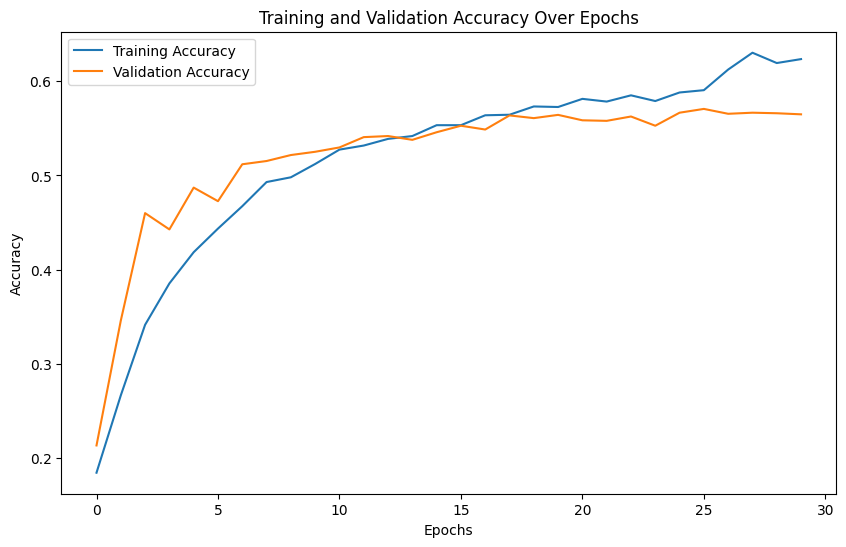

In [61]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Load Saved Components and Define the Prediction Logic

In [1]:
# Import required libraries
import pickle
from tensorflow.keras.models import load_model # type: ignore
import numpy as np
import re


# Load the TF-IDF Vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf = pickle.load(file)

# Load the Trained Neural Network Model
model = load_model('mbti_model.h5')

# Recompile the model to suppress warnings and ensure compatibility
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the Label Encoder
with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

In [62]:
# # Import required libraries
# import pickle
# from tensorflow.keras.models import load_model
# import numpy as np
# import re

# # Load the TF-IDF Vectorizer
# with open('tfidf_vectorizer.pkl', 'rb') as file:
#     tfidf = pickle.load(file)

# # Load the Trained Neural Network Model
# model = load_model('mbti_model.h5')

# # Recompile the model to suppress warnings and ensure compatibility
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Load the Label Encoder
# with open('label_encoder.pkl', 'rb') as file:
#     label_encoder = pickle.load(file)

# # Function to clean and preprocess user input
# def clean_text(text):
#     text = text.replace('|||', ' ')
#     text = text.lower()
#     text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
#     text = re.sub(r'\W', ' ', text)
#     text = re.sub(r'\d', '', text)
#     text = re.sub(r'\s+', ' ', text).strip()
#     return text

# # Function to predict MBTI type
# def predict_mbti(text, tfidf_vectorizer, model, label_encoder):
#     # Clean the user input
#     cleaned_text = clean_text(text)
#     print(f"Cleaned Text: {cleaned_text}")
    
#     # Transform the input using the trained TF-IDF vectorizer
#     input_tfidf = tfidf_vectorizer.transform([cleaned_text]).toarray().astype('float32')
#     print(f"TF-IDF Input Shape: {input_tfidf.shape}, Type: {type(input_tfidf)}")
    
#     # Ensure TF-IDF dimensions match the model's input dimensions
#     if input_tfidf.shape[1] > model.input_shape[1]:
#         input_tfidf = input_tfidf[:, :model.input_shape[1]]
#     elif input_tfidf.shape[1] < model.input_shape[1]:
#         raise ValueError(f"Model expects {model.input_shape[1]} features, but TF-IDF vectorizer produced {input_tfidf.shape[1]} features.")
    
#     print(f"Adjusted TF-IDF Input Shape: {input_tfidf.shape}")
    
#     # Predict the probabilities for each class
#     predictions = model.predict(input_tfidf)
#     print(f"Predictions: {predictions}")
    
#     # Get the class index with the highest probability
#     predicted_class_index = np.argmax(predictions)
#     print(f"Predicted Class Index: {predicted_class_index}")
    
#     # Decode the class index back to the MBTI type
#     predicted_mbti = label_encoder.inverse_transform([predicted_class_index])[0]
#     return predicted_mbti

# # Prompt the user for input
# print("Welcome to the MBTI Predictor!")
# user_input = input("Enter a short description or text: ")

# # Predict and display the MBTI type
# predicted_type = predict_mbti(user_input, tfidf, model, label_encoder)
# print(f"The predicted MBTI type is: {predicted_type}")
